In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='data/val', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['bacterial_blight', 'healthy', 'rust']


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython.display import clear_output












ModuleNotFoundError: No module named 'tensorflow_hub'

In [3]:
train_data_dir = '/kaggle/input/soybean-dataset/soybean_dataset'
BATCH_SIZE = 20
IMG_SIZE = (224, 224)
EPOCHS = 30
SHUFFLE_BUFFER = 1000
validation_split = 0.15 

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split, 
    subset='training',  
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split,  
    subset='validation',  
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split,  
    subset='test',  
)

Found 1468 files belonging to 3 classes.
Using 1248 files for training.
Found 1468 files belonging to 3 classes.
Using 220 files for validation.


In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(12):
        image = images[i].numpy()  
        label = labels[i]
        class_name = class_names[tf.argmax(label)]
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.astype("uint8"))  
        plt.title(class_name)
        plt.axis("off")  
plt.show()

AttributeError: 'ImageFolder' object has no attribute 'class_names'

In [5]:
#from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
def effnet_preprocess(x):
    """Preprocess input images manually for EfficientNet."""
    x = tf.image.convert_image_dtype(x, tf.float32)  # Scale [0, 255] → [0, 1]
    
    # ImageNet mean and std (Torch mode)
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    
    x = (x - mean) / std  
    return x

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

training_data = (train_dataset.map(lambda x, y: (data_augmentation(x), y))
                 .map(lambda x, y: (effnet_preprocess(x), y))
                 .shuffle(SHUFFLE_BUFFER).prefetch(1).cache())

validation_data = (validation_dataset.map(lambda x, y: (effnet_preprocess(x), y))
                   .prefetch(1).cache())

test_data = (validation_dataset.map(lambda x, y: (effnet_preprocess(x), y))
                   .prefetch(1).cache())

NameError: name 'tf' is not defined

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.utils import plot_model

In [8]:
#use all except for the last layer (specific to the 'imagenet' competition)
pretrained_model = EfficientNetV2L(input_shape = (224, 224,3), 
                              include_top = False,
                              weights = 'imagenet')

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


In [9]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='weights.weights.h5', 
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    ),
]


In [10]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [11]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(250, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │         320,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             753 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,067,851 (450.39 MB)

 Trainable params: 321,003 (1.22 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

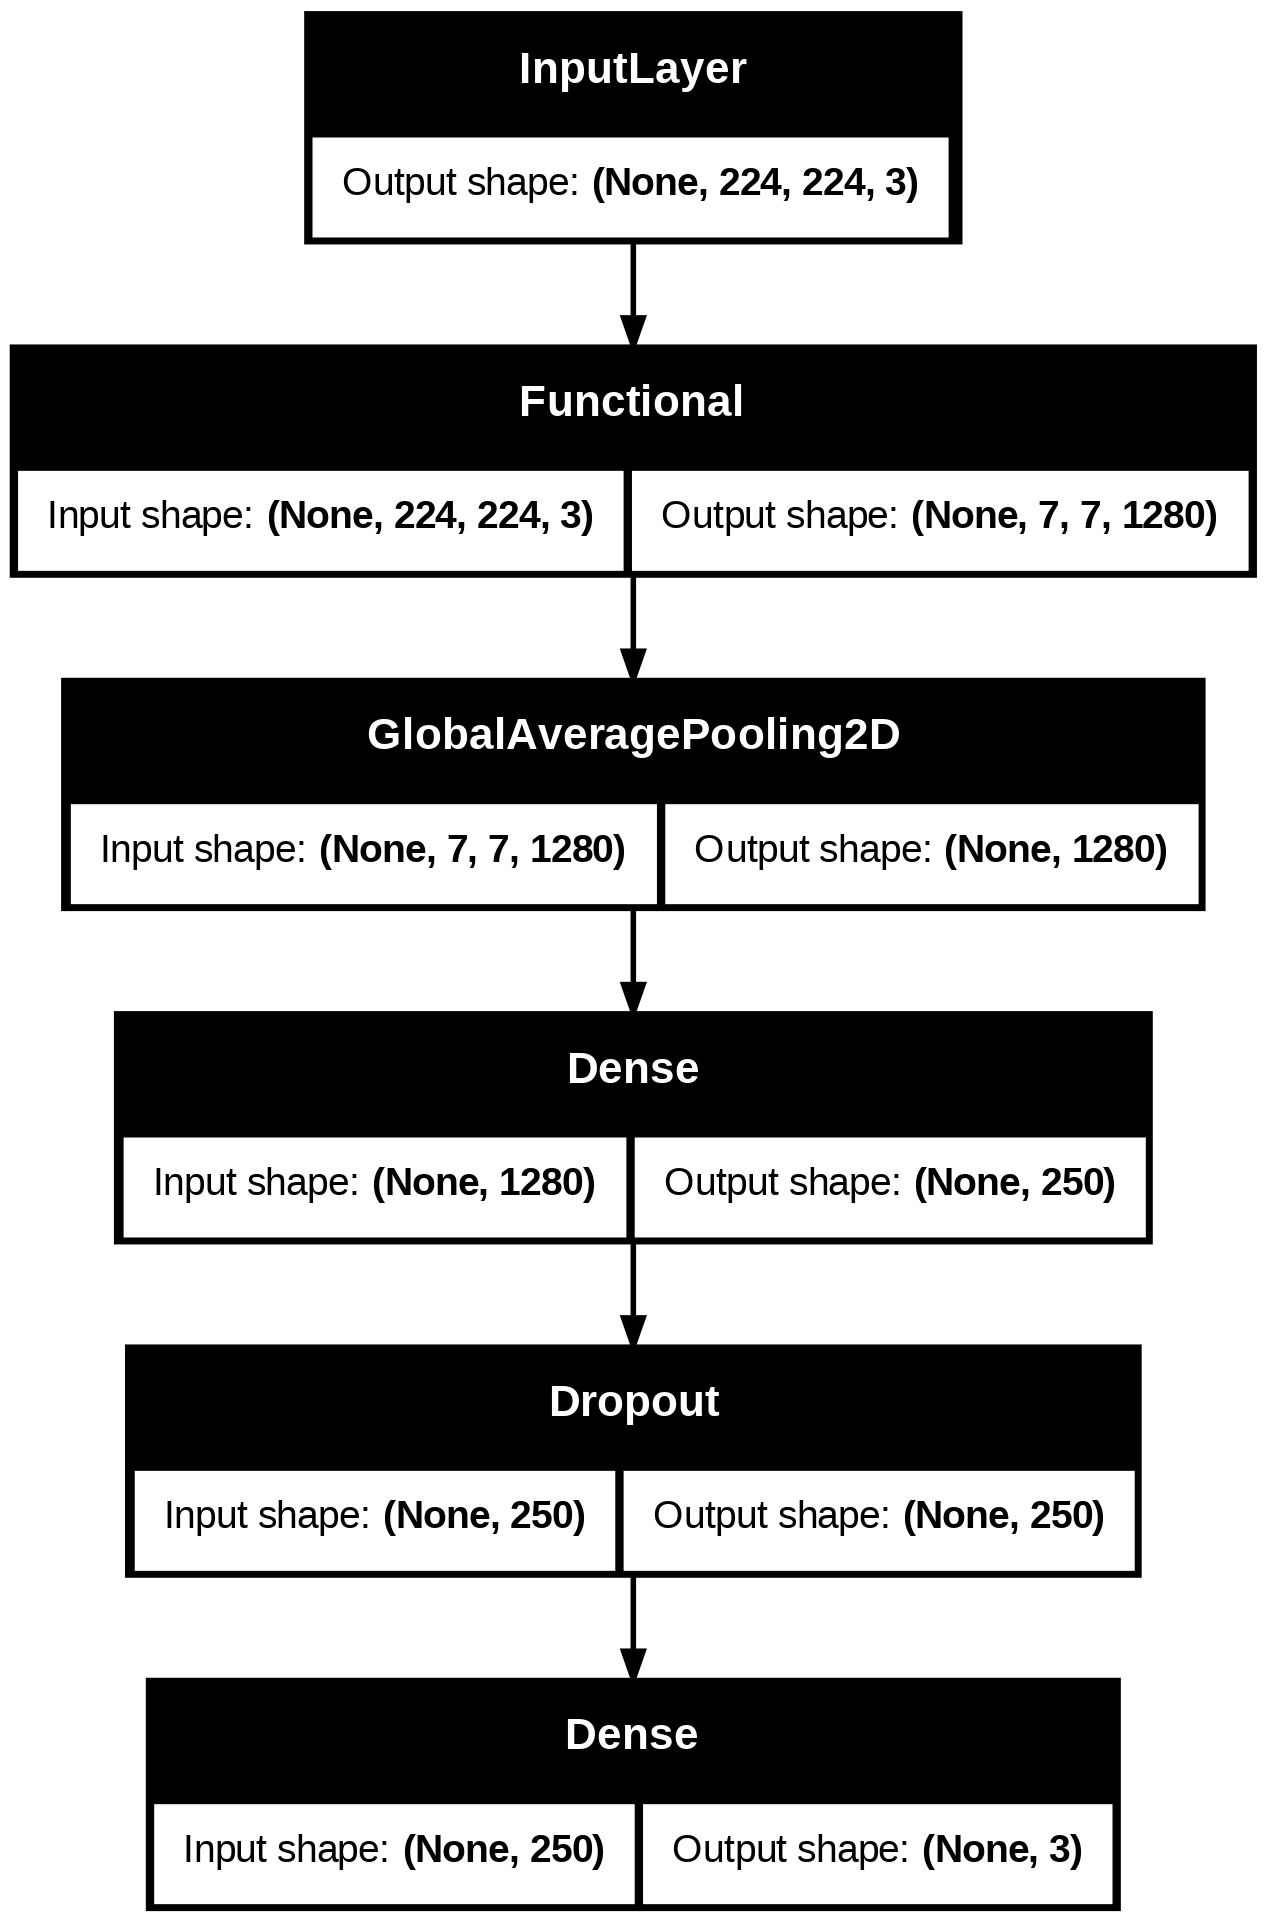

In [12]:
plot_model(model, show_shapes=True)

In [13]:
model.compile(loss='categorical_crossentropy',
             optimizer=rmsprop,
             metrics=['accuracy'])

history = model.fit(training_data, 
                    epochs=EPOCHS,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.4789 - loss: 0.9873 - val_accuracy: 0.7909 - val_loss: 0.5947
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.6816 - loss: 0.7435 - val_accuracy: 0.8409 - val_loss: 0.4677
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.7138 - loss: 0.6721 - val_accuracy: 0.8682 - val_loss: 0.4011
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.7393 - loss: 0.5857 - val_accuracy: 0.8818 - val_loss: 0.3524
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.7414 - loss: 0.5886 - val_accuracy: 0.8818 - val_loss: 0.3296
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.7726 - loss: 0.5455 - val_accuracy: 0.8818 - val_loss: 0.3220
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.7828 - loss: 0.5216 - val_accuracy: 0.8955 - val_loss: 0.3019
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.7872 - loss: 0.5315 - val_accura

In [14]:
model.evaluate(validation_data)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9093 - loss: 0.2663


[0.25326240062713623, 0.9136363863945007]